In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root_path = "/content/drive/MyDrive/data"

In [4]:
root_path = root_path + "/"

In [5]:
!pip install transformers
!pip install evaluate
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.3 MB/s 
     |████████████████████████████████| 182 kB 67.5 MB/s 
     |████████████████████████████████| 7.6 MB 38.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 1.0 MB/s 
     |████████████████████████████████| 451 kB 12.2 MB/s 
     |████████████████████████████████| 212 kB 47.1 MB/s 
     |████████████████████████████████| 132 kB 54.3 MB/s 
     |████████████████████████████████| 127 kB 30.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install -U pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [7]:
! pip install -U seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


In [8]:
import numpy as np
import pandas as pd

from datasets import load_dataset
from datasets import ClassLabel, Value

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import AdamW

from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import get_scheduler

import evaluate

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

# from tqdm.auto import tqdm
from tqdm.notebook import tqdm_notebook
import json
from itertools import chain

import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
train_file_path = root_path+'train.jsonl'
val_file_path = root_path+'validation.jsonl'

train_classification_data_svm_file_path = root_path+'train_classification_data_svm.jsonl'
undersampled_train_classification_data_svm_file_path = root_path+'undersampled_train_classification_data_svm.jsonl'
val_classification_data_svm_file_path = root_path+'val_classification_data_svm.jsonl'


In [10]:
# data preprocessing

def load_data(file_path):
  with open(file_path, 'r') as f:
    sentences = [json.loads(sentence.rstrip()) for sentence in f.readlines()]
    filtered_sentences = [{_key: _value for _key, _value in _sentence.items() if _key in ['uuid', 'postText', 'targetTitle', 'targetParagraphs', 'spoiler', 'spoilerPositions', 'tags']} for _sentence in sentences]
    return filtered_sentences

In [11]:
# load data

train_data = load_data(train_file_path)
val_data = load_data(val_file_path)

In [12]:
# reformat data and add proper spoiler positions using simple heuristics observed during data analysis

def reformat_spoiler_positions(data):
    reformatted_data = []
    ignore_idx = []

    for _idx, _sentence in enumerate(data):

        spoiler_positions = _sentence['spoilerPositions']
        target_title = _sentence['targetTitle']
        target_paragraphs = _sentence['targetParagraphs']
        all_target_paragraphs = [target_title] + target_paragraphs

        refactored_spoiler_positions = {}
        for _spoiler_passage_positions in spoiler_positions:
            if len(_spoiler_passage_positions) != 2:
                print('ignoring idx: {}'.format(_idx))
                ignore_idx.append(_idx)
                break

            _start_pos = _spoiler_passage_positions[0][1]
            _start_pos_passage = _spoiler_passage_positions[0][0]

            _end_pos = _spoiler_passage_positions[1][1]
            _end_pos_passage = _spoiler_passage_positions[1][0]

            if _start_pos_passage != _end_pos_passage:

                if _start_pos_passage == -1:
                    negative_mismatch_idx.append(_idx)

                _refactored_spoiler_positions = {}

                for _passage_idx in range(_start_pos_passage, _end_pos_passage):

                    if _passage_idx == _start_pos_passage:
                        _start = _start_pos - len(' '.join(target_paragraphs[:_passage_idx])) - 1
                        _refactored_spoiler_positions[_passage_idx + 1] = [
                            (_start if _start == 0 else _start - 1,
                             None)]

                    elif _passage_idx == _end_pos_passage:
                        _refactored_spoiler_positions[_passage_idx + 1] = [(None, _end_pos - 1 - len(' '.join(target_paragraphs[:_passage_idx])))]

                    else:
                        _refactored_spoiler_positions[_passage_idx + 1] = [(None, None)]

                for _key, _value in _refactored_spoiler_positions.items():
                    if _key not in refactored_spoiler_positions:
                        refactored_spoiler_positions[_key] = _value 
                    else:
                        refactored_spoiler_positions[_key].extend(_value)

            else:
                if _start_pos_passage + 1 not in refactored_spoiler_positions:
                    refactored_spoiler_positions[_start_pos_passage + 1] = [(_start_pos, _end_pos)]
                else:
                    refactored_spoiler_positions[_start_pos_passage + 1].append((_start_pos, _end_pos))

        reformatted_data.append({**_sentence, 'allTargetParagraphs': all_target_paragraphs, 'refactoredSpoilerPositions': refactored_spoiler_positions})
        
    return reformatted_data, ignore_idx


In [13]:
# reformat data with proper spoiler positions

train_data_reformatted, _ = reformat_spoiler_positions(data=train_data)
val_data_reformatted, _ = reformat_spoiler_positions(data=val_data)

ignoring idx: 546


In [14]:
# remove data datapoints where the spoiler positions don't match the actual spoiler text

def remove_bad_matches_data(data):

    exact_match_bad_annotations = []
    exact_match_bad_annotations_ids = []
    not_found_exact_matchs = {}

    clean_data = []

    for _idx, _sentence in enumerate(data):
        for _key in _sentence['refactoredSpoilerPositions'].keys():
            for _value_idx in range(len(_sentence['refactoredSpoilerPositions'][_key])):
        
                _start_pos = _sentence['refactoredSpoilerPositions'][_key][_value_idx][0]
                _end_pos = _sentence['refactoredSpoilerPositions'][_key][_value_idx][1]

                if _sentence['allTargetParagraphs'][_key][_start_pos: _end_pos] not in _sentence['spoiler'] and not any(True for _spoiler in _sentence['spoiler'] if _sentence['allTargetParagraphs'][_key][_start_pos: _end_pos] in _spoiler):
                    exact_match_bad_annotations.append(_sentence)
                    exact_match_bad_annotations_ids.append(_idx)
                    if _idx not in not_found_exact_matchs:
                        not_found_exact_matchs[_idx] = [_sentence['allTargetParagraphs'][_key][_start_pos: _end_pos]]
                    else:
                        not_found_exact_matchs[_idx].append(_sentence['allTargetParagraphs'][_key][_start_pos: _end_pos])
                else:
                    clean_data.append(_sentence)
  
    return clean_data, exact_match_bad_annotations_ids, not_found_exact_matchs



In [15]:
# clean data

clean_train_data, _, not_found_spoilers_train = remove_bad_matches_data(data=train_data_reformatted)
clean_val_data, _, not_found_spoilers_val = remove_bad_matches_data(data=val_data_reformatted)

In [16]:
# flatten nested data.
# change_multi true will relable the multi-spoiler data as either phrase or passage depending on
# the length of spoiler.

def flatten_data(data, change_multi=True):
    flattened_data = []
    for _sentence in data:

        uuid = _sentence['uuid']
        post = ' '.join(_sentence['postText'])
        target_title = _sentence['targetTitle']
        target_paragraphs = _sentence['allTargetParagraphs']
        spoiler_positions = _sentence['refactoredSpoilerPositions']
        spoiler_type = _sentence['tags']

        for _idx, _target_paragraph in enumerate(target_paragraphs):
            _spoiler_pos = spoiler_positions.get(_idx, None)

            if not change_multi and spoiler_type[0] != 'multi':
                _data = {
                    'uuid': uuid,
                    'targetParagraphId': _idx,
                    'postText': post,
                    'targetTitle': target_title,
                    'targetParagraph': _target_paragraph,
                    'spoilerType': spoiler_type[0] if _spoiler_pos else None,
                    'spoilerPos': _spoiler_pos if _spoiler_pos else None
                }
                flattened_data.append(_data)

            else:
                _spoiler_type = None
                if _spoiler_pos:
                    if spoiler_type[0] != 'multi':
                        _spoiler_type = spoiler_type[0]
                    else:
                        _spoiler_texts = ([_target_paragraph[__spoiler_pos[0]: __spoiler_pos[1]] for __spoiler_pos in _spoiler_pos])
                        _max_length = max([len(_x.split(' ')) for _x in _spoiler_texts])
                        if _max_length <=5:
                            _spoiler_type = 'phrase'
                        else:
                            _spoiler_type = 'passage'

                _data = {
                    'uuid': uuid,
                    'targetParagraphId': _idx,
                    'postText': post,
                    'targetTitle': target_title,
                    'targetParagraph': _target_paragraph,
                    'spoilerType': _spoiler_type,
                    'spoilerPos': _spoiler_pos if _spoiler_pos else None
                }
                flattened_data.append(_data)

    return flattened_data

In [17]:
# flattened data

flattened_train_data = flatten_data(data=clean_train_data, change_multi=True)
flattened_val_data = flatten_data(data=clean_val_data, change_multi=True)

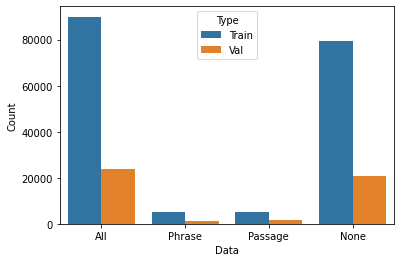

In [18]:
# flattened data distribution

distribution_df = pd.DataFrame(columns=["Data", "Type", "Count"], data={
    "Data":['All', 'All', 'Phrase', 'Phrase', 'Passage', 'Passage', 'None', 'None'],
    "Count": [len(flattened_train_data),
              len(flattened_val_data),
              len([_x for _x in flattened_train_data if _x['spoilerType'] == 'phrase']),
              len([_x for _x in flattened_val_data if _x['spoilerType'] == 'phrase']),
              len([_x for _x in flattened_train_data if _x['spoilerType'] == 'passage']),
              len([_x for _x in flattened_val_data if _x['spoilerType'] == 'passage']),
              len([_x for _x in flattened_train_data if _x['spoilerType'] == None]),
              len([_x for _x in flattened_val_data if _x['spoilerType'] == None])],
    "Type": ['Train', 'Val', 'Train', 'Val', 'Train', 'Val', 'Train', 'Val']
})
sns.barplot(distribution_df, x="Data" , y="Count", hue="Type")


In [19]:
# prepare classification data

def prepare_classification_data(flattened_data, undersample_ratio=1.0):
    clasification_data = []
    undersampled_data = []
    
    for _x in flattened_data:
        
        _label = 0        
        if _x['spoilerType'] == 'phrase':
            _label = 1
        elif _x['spoilerType'] == 'passage':
            _label = 2

        _data = {
            'uuid': _x['uuid'],
            'targetParagraphId': _x['targetParagraphId'],
            'text': _x['postText'] + ' ' + _x['targetParagraph'],
            'labels': _label,
            # **_x
          }
        clasification_data.append(_data)
    
    none_data = [_data for _data in clasification_data if _data['labels'] == 0]
    len_undersampled = int(len(none_data)*undersample_ratio)
    for _data in np.random.choice(none_data, size=len_undersampled, replace=False):
        undersampled_data.append(_data)
    for _x in clasification_data:
        if _x['labels'] in [1, 2]:
            undersampled_data.append(_x)
    
    return undersampled_data

In [20]:
# create data for svm

classification_train_data = prepare_classification_data(flattened_data=flattened_train_data)
undersampled_classification_train_data = prepare_classification_data(flattened_data=flattened_train_data, undersample_ratio=0.3)
classification_val_data = prepare_classification_data(flattened_data=flattened_val_data)


In [21]:
# reformat the data as a dataframe

df_classification_train = pd.DataFrame(columns=['text', 'labels'], data=undersampled_classification_train_data)
df_classification_val = pd.DataFrame(columns=['text', 'labels'], data=classification_val_data)



In [22]:
# train svm

x_train, x_test, y_train, y_test = df_classification_train['text'], df_classification_val['text'], df_classification_train['labels'], df_classification_val['labels']

# Encode Labels
label_encoder = preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Encode the preprocessed tweets as TF-IDF vectors
vectorizer = TfidfVectorizer(ngram_range = (1, 2), min_df=3, smooth_idf=True)
x_train_vector = vectorizer.fit_transform(x_train)
x_test_vector = vectorizer.transform(x_test)

# Classifier
# weighting didn't work well. We got the best results on grid search using equal weights
# clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-4, max_iter=500, tol=None, shuffle=True, random_state=20221201)
clf = svm.SVC(kernel="linear", max_iter=500, C=1.0, gamma='scale')

clf.fit(x_train_vector, y_train_encoded)
y_pred = clf.predict(x_test_vector)

# results

print("Results on Testing Data Set")
print()

accuracy = accuracy_score(y_test_encoded, y_pred)
print('Classificaation Accuracy: {}'.format(accuracy))
print()

report = classification_report(y_test_encoded, y_pred)
print('Classification Report')
print(report)
print()


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Results on Testing Data Set

Classificaation Accuracy: 0.7081546868432115

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.78      0.83     20972
           1       0.08      0.22      0.11      1362
           2       0.07      0.06      0.07      1456

    accuracy                           0.71     23790
   macro avg       0.34      0.36      0.34     23790
weighted avg       0.79      0.71      0.74     23790




/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


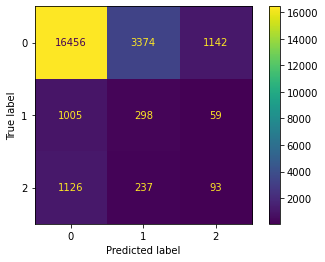

In [23]:
# confusion matrix
plot_confusion_matrix(clf, x_test_vector, y_test_encoded)
plt.show()

In [24]:
pass